## Orientation feature tracking hybrid
We do limbus detection using Hough transform, where we obtain translation and scale. We manually pick the zeroth degree in initial frame. Then features are detected and rotation is estimated relative to the first frame.

### 1. Imports

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from helpers.limbus_detection import detect_circle
from helpers.video_manipulation import extract_consecutive

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Limbus tracking

In [14]:
WINDOW_SIZE = 15

cap = cv2.VideoCapture('data/artificial/rhexis_input_long_rotating2_lofi.mp4')
circles_window = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]

    # limbus circle detection
    cur_circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )
    circles_window.append(cur_circle)
    if len(circles_window) > WINDOW_SIZE:
        circles_window = circles_window[1:WINDOW_SIZE+1]
    
    total_circles = 0
    best_circle = np.zeros(3)
    for circle in circles_window:
        if circle is None:
            continue
            
        total_circles += 1
        best_circle += circle
        
    if total_circles != 0:
        best_circle /= total_circles
        cv2.circle(base, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), thickness=5, lineType=cv2.LINE_AA)

    cv2.imshow('result', base)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)


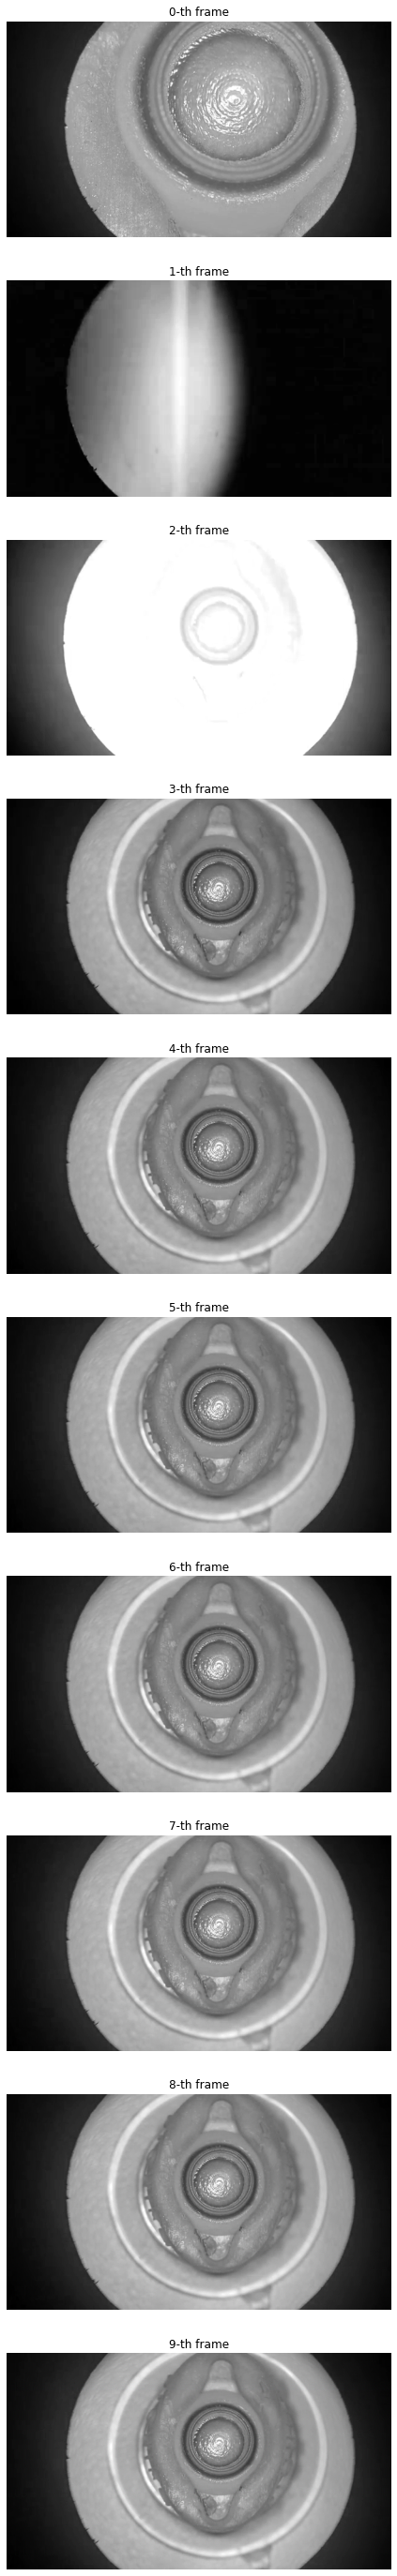

In [39]:
video_path = 'data/artificial/rhexis_input_long_rotating2_lofi.mp4'

frame_start = 73*30
frame_count = 8*30
representatives = 10
frames_full = extract_consecutive(
    video_path, frame_start, frame_start+frame_count, mode='hsv')
frames = []
for i in range(representatives):
    frames.append(frames_full[int(i * (len(frames_full) / representatives))])

_, plots = plt.subplots(len(frames), 1, figsize=(15, 5*len(frames)))
for i, frame in enumerate(frames):
    plots[i].set_title('%s-th frame' % i)
    plots[i].imshow(frame[:, :, 2], cmap='gray')
    plots[i].axis('off')

plt.show()

In [40]:
limbus_circles = []

for frame in frames:
    circle = detect_circle(
        frame[:, :, 2],
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )

    limbus_circles.append(circle)

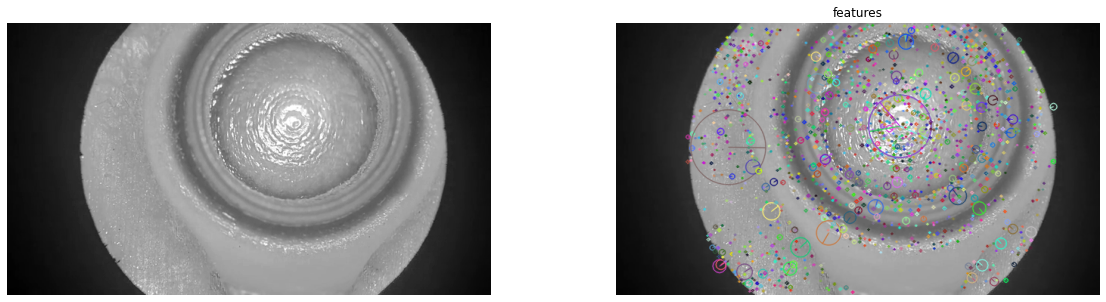

1750 keypoints detected


In [42]:
keypoint_target = frames[0][:, :, 2]

sift = cv2.SIFT_create(contrastThreshold=0.01)
sift_keypoints = sift.detect(keypoint_target, None)

keypoint_target_result = cv2.drawKeypoints(keypoint_target, sift_keypoints, None,
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 5))
plot1.set_title('')
plot1.imshow(keypoint_target, cmap='gray')
plot1.axis('off')

plot2.set_title('features')
plot2.imshow(cv2.cvtColor(keypoint_target_result, cv2.COLOR_BGR2RGB))
plot2.axis('off')

plt.show()

print('%s keypoints detected' % len(sift_keypoints))

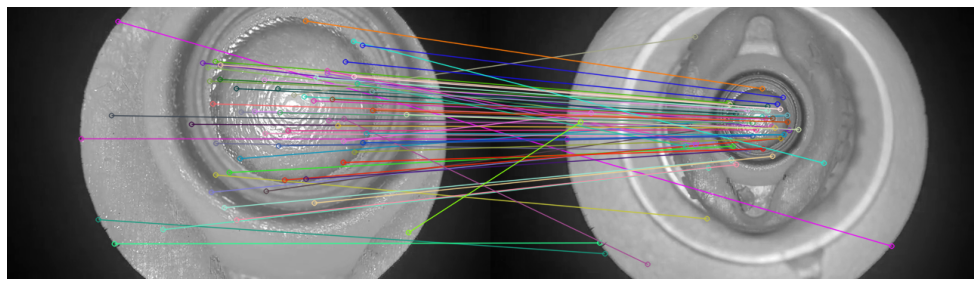

59 good matches found


In [43]:
from_index = 0
to_index = -1

keypoint_target_from = frames[from_index][:, :, 2]
limbus_circle_from = limbus_circles[from_index]
keypoint_target_to = frames[to_index][:, :, 2]
limbus_circle_to = limbus_circles[to_index]

assert (limbus_circle_from is not None) and (limbus_circle_to is not None)

# SIFT detector initialization
sift = cv2.SIFT_create(contrastThreshold=0.01)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(keypoint_target_from, None)
kp2, des2 = sift.detectAndCompute(keypoint_target_to, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# ratio test
good = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

matches_vis = cv2.drawMatchesKnn(keypoint_target_from, kp1, keypoint_target_to, kp2, good, None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, plot = plt.subplots(1, 1, figsize=(20, 5))
plot.imshow(matches_vis)
plot.axis('off')

plt.show()

print('%s good matches found' % len(good))

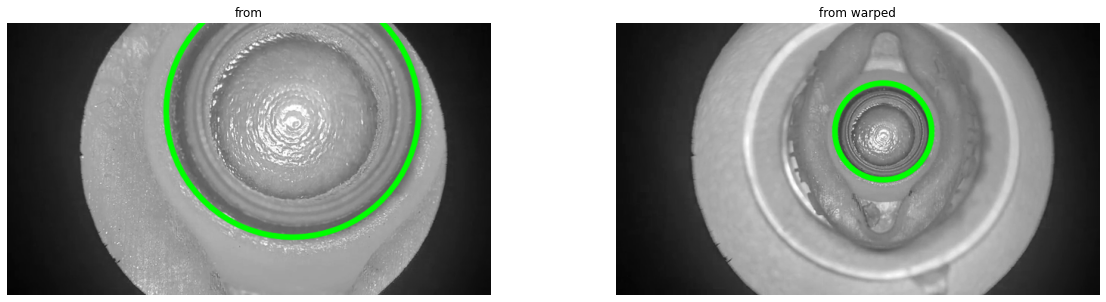

In [44]:
limbus_detection_from = cv2.cvtColor(keypoint_target_from, cv2.COLOR_GRAY2RGB)
limbus_detection_to = cv2.cvtColor(keypoint_target_to, cv2.COLOR_GRAY2RGB)

cv2.circle(limbus_detection_from, (round(limbus_circle_from[0]), round(limbus_circle_from[1])), round(
            limbus_circle_from[2]), (0, 255, 0), thickness=5, lineType=cv2.LINE_AA)
cv2.circle(limbus_detection_to, (round(limbus_circle_to[0]), round(limbus_circle_to[1])), round(
            limbus_circle_to[2]), (0, 255, 0), thickness=5, lineType=cv2.LINE_AA)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 5))
plot1.set_title('from')
plot1.imshow(limbus_detection_from)
plot1.axis('off')

plot2.set_title('from warped')
plot2.imshow(limbus_detection_to)
plot2.axis('off')

plt.show()

In [63]:
translation

array([-9.239617, 10.266243], dtype=float32)

In [65]:
keypoint_target_from.shape

(360, 640)

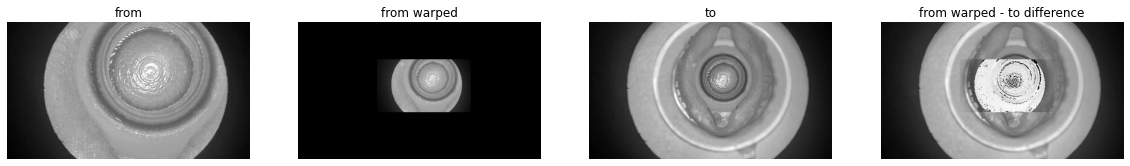

In [66]:
scale =  limbus_circle_to[2] / limbus_circle_from[2]
translation = (limbus_circle_to[:2] - scale * limbus_circle_from[:2])
transform = np.array([
    [scale, 0    , translation[0]],
    [0    , scale, translation[1]]
])

keypoint_target_from_warped = cv2.warpAffine(keypoint_target_from, transform,
                                             (keypoint_target_to.shape[1], keypoint_target_to.shape[0]))

diff = cv2.normalize(keypoint_target_to - keypoint_target_from_warped, None,
                     alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

fig, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4, figsize=(20, 5))
plot1.set_title('from')
plot1.imshow(keypoint_target_from, cmap='gray')
plot1.axis('off')

plot2.set_title('from warped')
plot2.imshow(keypoint_target_from_warped, cmap='gray')
plot2.axis('off')

plot3.set_title('to')
plot3.imshow(keypoint_target_to, cmap='gray')
plot3.axis('off')

plot4.set_title('from warped - to difference')
plot4.imshow(diff, cmap='gray')
plot4.axis('off')

plt.show()

In [24]:

points_from = np.array([kp1[m[0].queryIdx].pt for m in good])
points_to = np.array([kp2[m[0].trainIdx].pt for m in good])

transform, inliers = cv2.estimateAffinePartial2D(
    np.array([kp1[m[0].queryIdx].pt for m in good]),
    np.array([kp2[m[0].trainIdx].pt for m in good])
)
print(transform)

[[ 1.69764057e+00  8.73700205e-03 -2.33636838e+02]
 [-8.73700205e-03  1.69764057e+00 -1.22803232e+02]]


In [22]:
kp1[good[0][0].queryIdx].pt

(111.90726470947266, 242.90101623535156)

In [25]:
np.array([kp1[m[0].queryIdx].pt for m in good])

array([[111.90726471, 242.90101624],
       [134.09585571, 295.60882568],
       [140.71734619,  39.35174942],
       [143.07252502,  46.74081039],
       [175.46969604, 347.34597778],
       [219.93640137, 144.83607483],
       [220.38082886, 121.35578156],
       [240.70655823, 140.85922241],
       [243.33004761, 154.5933075 ],
       [249.20391846, 204.93891907],
       [250.86000061, 175.82221985],
       [254.29490662,  91.19725037],
       [255.13630676, 160.51676941],
       [255.49067688,  31.61602592],
       [258.6194458 , 109.08041382],
       [259.21960449,  97.84719086],
       [264.71890259, 198.88694763],
       [266.82565308, 251.06036377],
       [267.3553772 ,  98.10222626],
       [268.83847046, 135.59191895],
       [269.12948608, 238.16098022],
       [270.05725098, 210.69534302],
       [271.56625366, 129.04801941],
       [272.22369385,  54.83980179],
       [273.08703613, 101.4205246 ],
       [273.41351318,  96.88205719],
       [274.90188599,  73.79633331],
 